# Clustering : DBSCAN, HDBSCAN, GMM

This notebook was heavily inspired by [Tristan Cantat-Gaudins](https://github.com/TristanCantatGaudin/playground/blob/main/dbscan_ngc_2506.ipynb) notebook

Clustering is a branch of unsupervised learning that concerns itself with organizing data in groups whose members share similar properties. It can be formulated as an optmization problem: We can choose a 'cost' (or 'objective') function which measures the 'quality' of the clustering structure and then try to find the partition that maximizes the objective function.  The cost function usually depends on a measure of similarity in feature space, most common choice is Eucledian distance between two points.

Some terminology:
- **Partitional Clustering:** Each object belongs to one and only one cluster, has a 'global' cost function
- **Hierarchical Clustering:** Clusters can be nested within one another. Often displayed in form of a dendrogram. Has a 'local' cost function 


## 1 DBSCAN
= **Density Based Spatial Clustering of Applications with Noise:** works by identifying clusters as areas of high density, separated by regions of lower density. We need to set a distance measure, however (unlike as for k-means) we do not need to know the number of clusters. Because these clusters are built locally, and on the basis of the vicinity of points, clusters of arbitrary shapes can be detected via DBSCAN. DBSCAN is characterized by two parameters:
-  $\epsilon$ : a threshold for proximity
- $n_{min}$ : minimum of points in a high-density neighbourhood

This local clustering can be an advantage but as it turns out, the algorithm is highly reliant on on the proximity threshold $\epsilon$ and influences the number of clusers found greatly. The $\epsilon$ value is a hyperparameter and we can hunt empirically for the best $\epsilon$ value, which for instance is attempting to measure the 'typical density scale'

#### 1.1 Algorithm
The algorithm will assign each one of three labels:
- core: has at least $n_{min}$ other samples within a distance of  $\epsilon$
- border: sample is a neighbour (is in distance of  $\epsilon$) of a core sample but is not itself a core sample
- noise: points not in distance of  $\epsilon$ of any other point

For each unassigned sample $x_i$:
- if $x_i$ is already assigned to a cluster, do nothing
- if $x_i$ is not a core point (has less than $n_{min}$ neighbours), do nothing: Check whether there are at least $n_{min}$ points within a distance of $\epsilon$ (Is the point a core sample?)
- if if $x_i$ is a core point: Implement 'Expand Cluster' Sequence

Expand cluster sequence:

- Assign all $x_i$ within a distance $\epsilon$ of the current core sample to cluster 
- For each newly assigned neighbour $x_i$ (that is the core point), implement the 'expand the cluster' sequence around $x_i$


In [18]:
from astroquery.gaia import Gaia
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from scipy.cluster import hierarchy

cmap = plt.get_cmap('berlin')
plt.style.use('/Users/niederbrunner/Documents/research/evaporationages/light.mplstyle')

In [4]:
%%time
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited

RA = 120.0
DEC = -10.76
RADIUS = 0.4

queryStringGaia = """select * from gaiadr3.gaia_source
                    where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',%.3f,%.3f,%.3f))
                    and phot_g_mean_mag<18 and pmra is not null""" % (RA,DEC,RADIUS)

job = Gaia.launch_job_async(queryStringGaia,
                    dump_to_file=False, output_format='votable')
                    
GaiaT = job.get_results()
df_cluster = GaiaT.to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 1.08 s, sys: 81.7 ms, total: 1.16 s
Wall time: 7.63 s


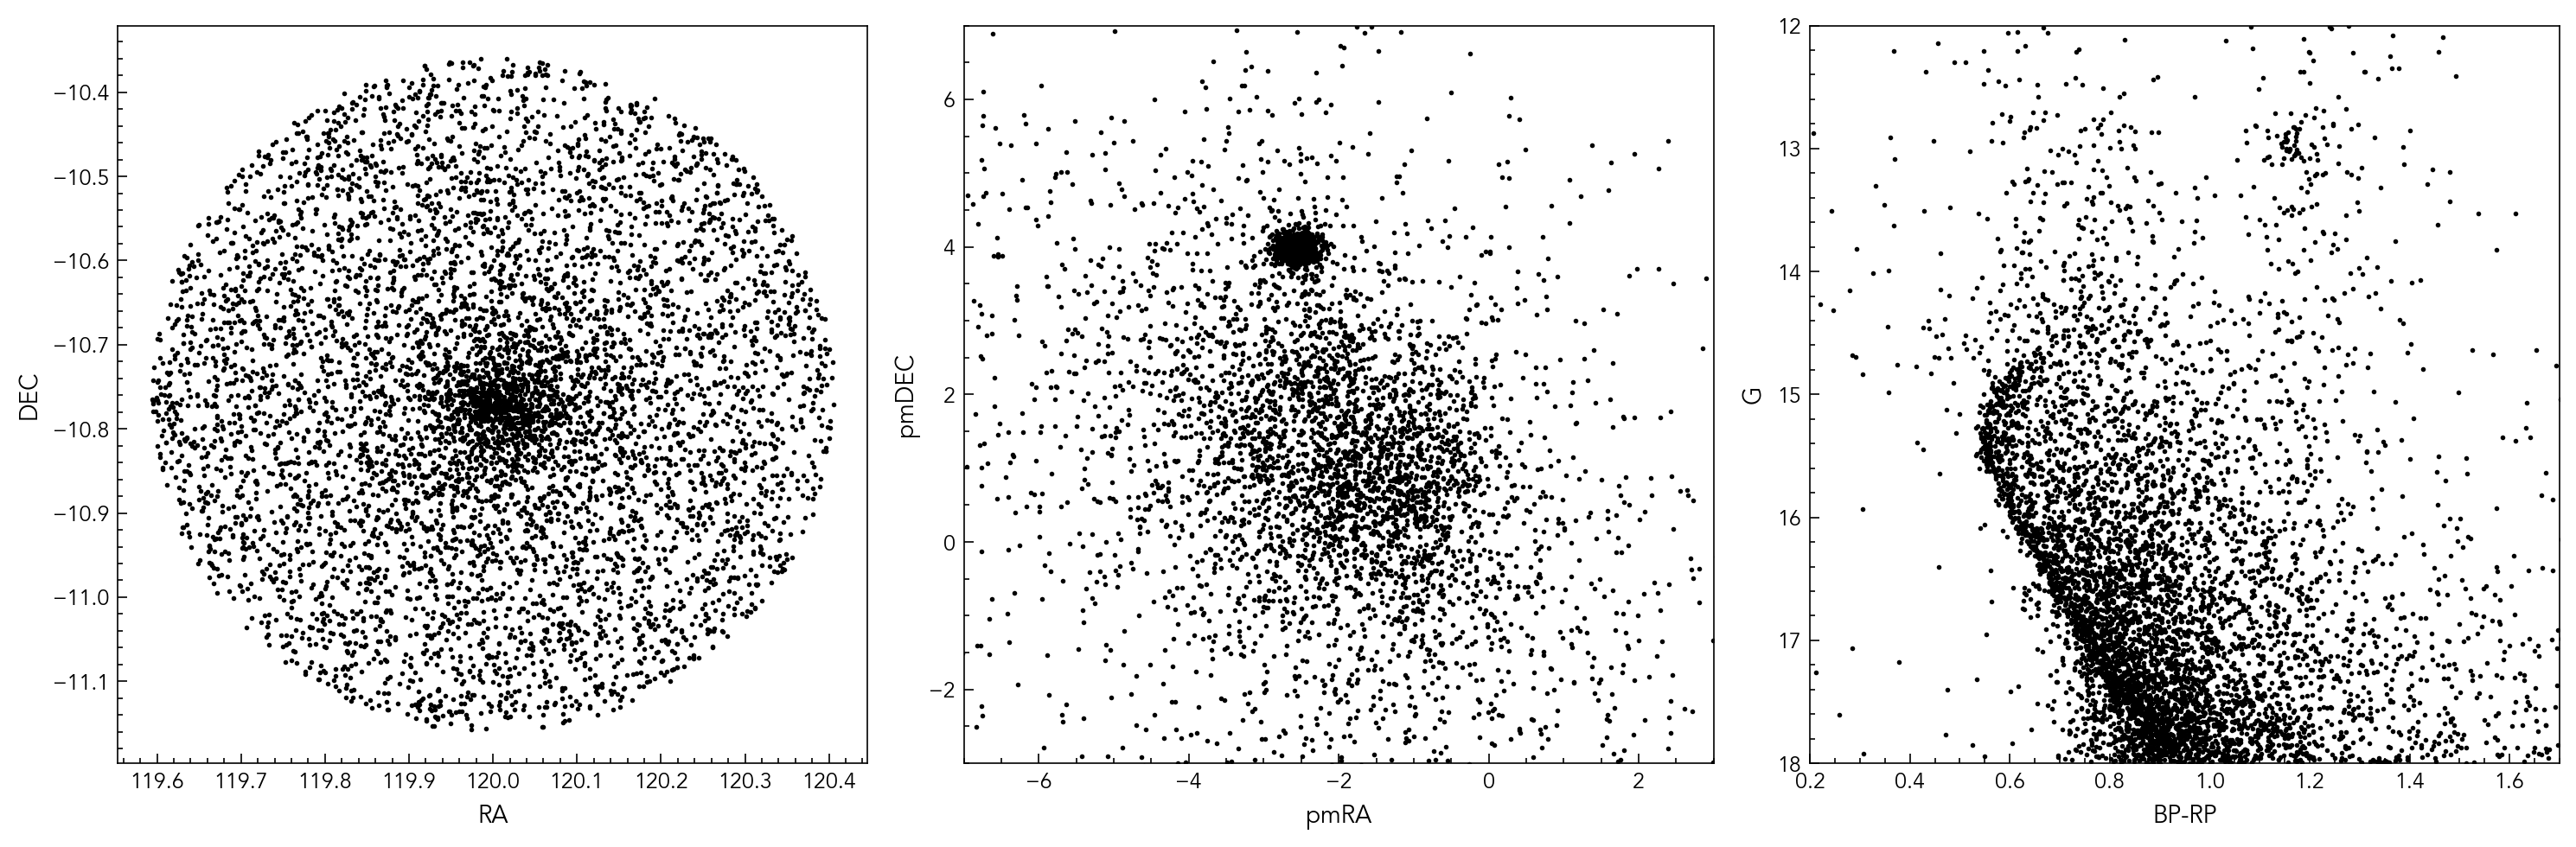

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.scatter(df_cluster['ra'], df_cluster['dec'], s = 1)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

ax2.scatter(df_cluster['pmra'], df_cluster['pmdec'], s = 1)
ax2.set_xlim(-7,3), ax2.set_ylim(-3,7)
ax2.set_xlabel('pmRA')
ax2.set_ylabel('pmDEC')


ax3.scatter(df_cluster['bp_rp'], df_cluster['phot_g_mean_mag'], s = 1)
ax3.set_xlim(0.2,1.7), ax3.set_ylim(18,12)
ax3.set_xlabel('BP-RP')
ax3.set_ylabel('G')

plt.show()

Skikit Learn DBSCAN has a worst case memory complexity of $\mathcal{O(n^2)}$, which can occur when the $\epsilon$ is large and $n_{min}$ is low, while the original DBSCAN only uses linear memory. 
```python
sklearn.cluster.DBSCAN(
    eps=0.5, *,
    min_samples=5,
    metric='euclidean',
    metric_params=None,
    algorithm='auto',
    leaf_size=30,
    p=None,
    n_jobs=None)


fit(X, y=None, sample_weight=None)
```
- X ... training instances to cluster
- y ... ignored, just by convention
- sample_weight ... weight of each sample, such that the sample with a weight of at least `min_samples` is by itself a core sample
- Returns a fitted instance of self

Noisy samples are given the label -1

In [6]:
X = np.array([df_cluster['pmra'] , df_cluster['pmdec']]).T

db = DBSCAN(eps=0.3, min_samples=100).fit(X)

n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0) # we are counting the number of clusters, excluding the noise points
n_noise_ = list(db.labels_).count(-1)   # we are counting the number of noise points, aka our field stars 


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 4586


<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
/var/folders/q3/y056j4qj62q3ntwz2hpjtv040000gn/T/ipykernel_36791/4135578972.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.suptitle('DBSCAN: $\epsilon$ = 0.3, $n_{\mathrm{min}}$ = 100')


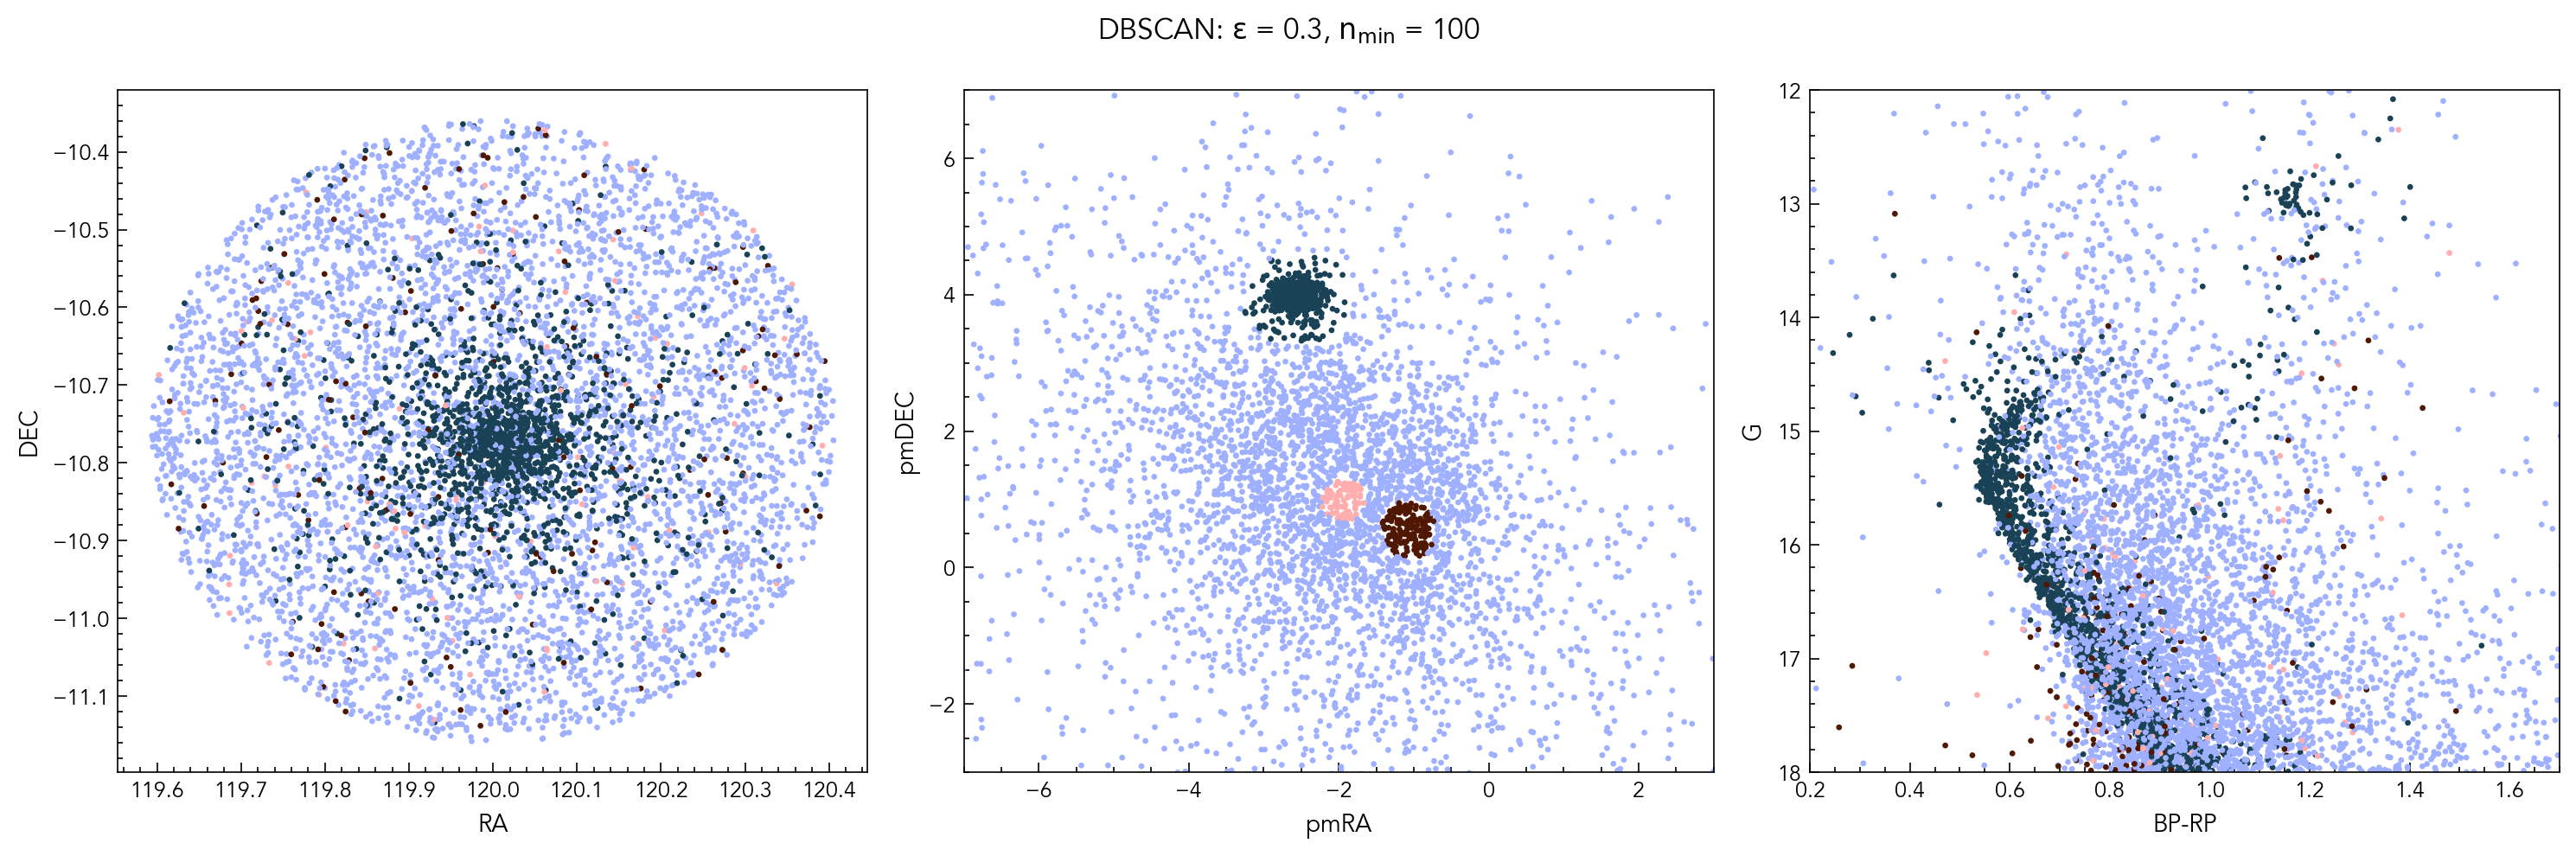

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
plt.suptitle('DBSCAN: $\epsilon$ = 0.3, $n_{\mathrm{min}}$ = 100')

ax1.scatter(df_cluster['ra'], df_cluster['dec'], c = db.labels_, s = 2, cmap = cmap)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

ax2.scatter(df_cluster['pmra'], df_cluster['pmdec'], c = db.labels_, s = 2, cmap = cmap)
ax2.set_xlim(-7,3), ax2.set_ylim(-3,7)
ax2.set_xlabel('pmRA')
ax2.set_ylabel('pmDEC')

ax3.scatter(df_cluster['bp_rp'], df_cluster['phot_g_mean_mag'], c = db.labels_, s = 2, cmap = cmap)
ax3.set_xlim(0.2,1.7), ax3.set_ylim(18,12)
ax3.set_xlabel('BP-RP')
ax3.set_ylabel('G')

plt.show()

## 2 HDBSCAN
= **Hierarchical Density Based Spatial Clustering of Applications with Noise:** avoids the problem that DBSCAN has with the fixed radius by recording the clusters as we vary the radius (keep minimum neighbours fixed). 
HDBSCAN computes nearest neighbour distances as with DBSCAN, however HDBSCAN then effectively considers all possible DBSCAN solutions for all possible values of $\epsilon$, constructing a hierarchical tree representation of the possible clusterings of the data set. This solves the problem of DBSCAN that we are struggling to recover clusters with different densities
- **$m_{\mathrm{cl,Size}}$:** HDBSCAN replaces $\epsilon$ with a minimum cluster size $m_{\mathrm{cl,Size}}$ which is used to define the minimum possible size of a cluster before all points within it are instead classified as noise. Smaller values cause the hierarchical graph to be split more and deeper, larger values will merge small groups, negating the algorithms sensitivity to cluster to clusters smaller than this minimum cluster size. 

``` python
hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=None,
    metric='euclidean',
    alpha=1.0,
    p=None,
    algorithm='best',
    leaf_size=40,
    memory=Memory(location=None),
    approx_min_span_tree=True,
    gen_min_span_tree=False,
    core_dist_n_jobs=4,
    cluster_selection_method='eom',
    allow_single_cluster=False,
    prediction_data=False,
    match_reference_implementation=False
)

fit(X, y=None)
```
- X: Input data points that need to be clustered.
- y: Ignored, only included by convention to match the scikit-learn API.
- Returns: A fitted instance of HDBSCAN, allowing access to cluster labels, probabilities, and outliers.

Noisy samples (points that do not belong to any cluster) are assigned the label -1. Unlike DBSCAN, HDBSCAN can also return soft clustering by providing the probability of cluster membership for each point.

In [9]:
hdb = HDBSCAN(min_cluster_size = 25).fit(X)

n_clusters_ = len(set(hdb.labels_)) - (1 if -1 in hdb.labels_ else 0) # we are counting the number of clusters, excluding the noise points
n_noise_ = list(hdb.labels_).count(-1)   # we are counting the number of noise points, aka our field stars 


print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 3187


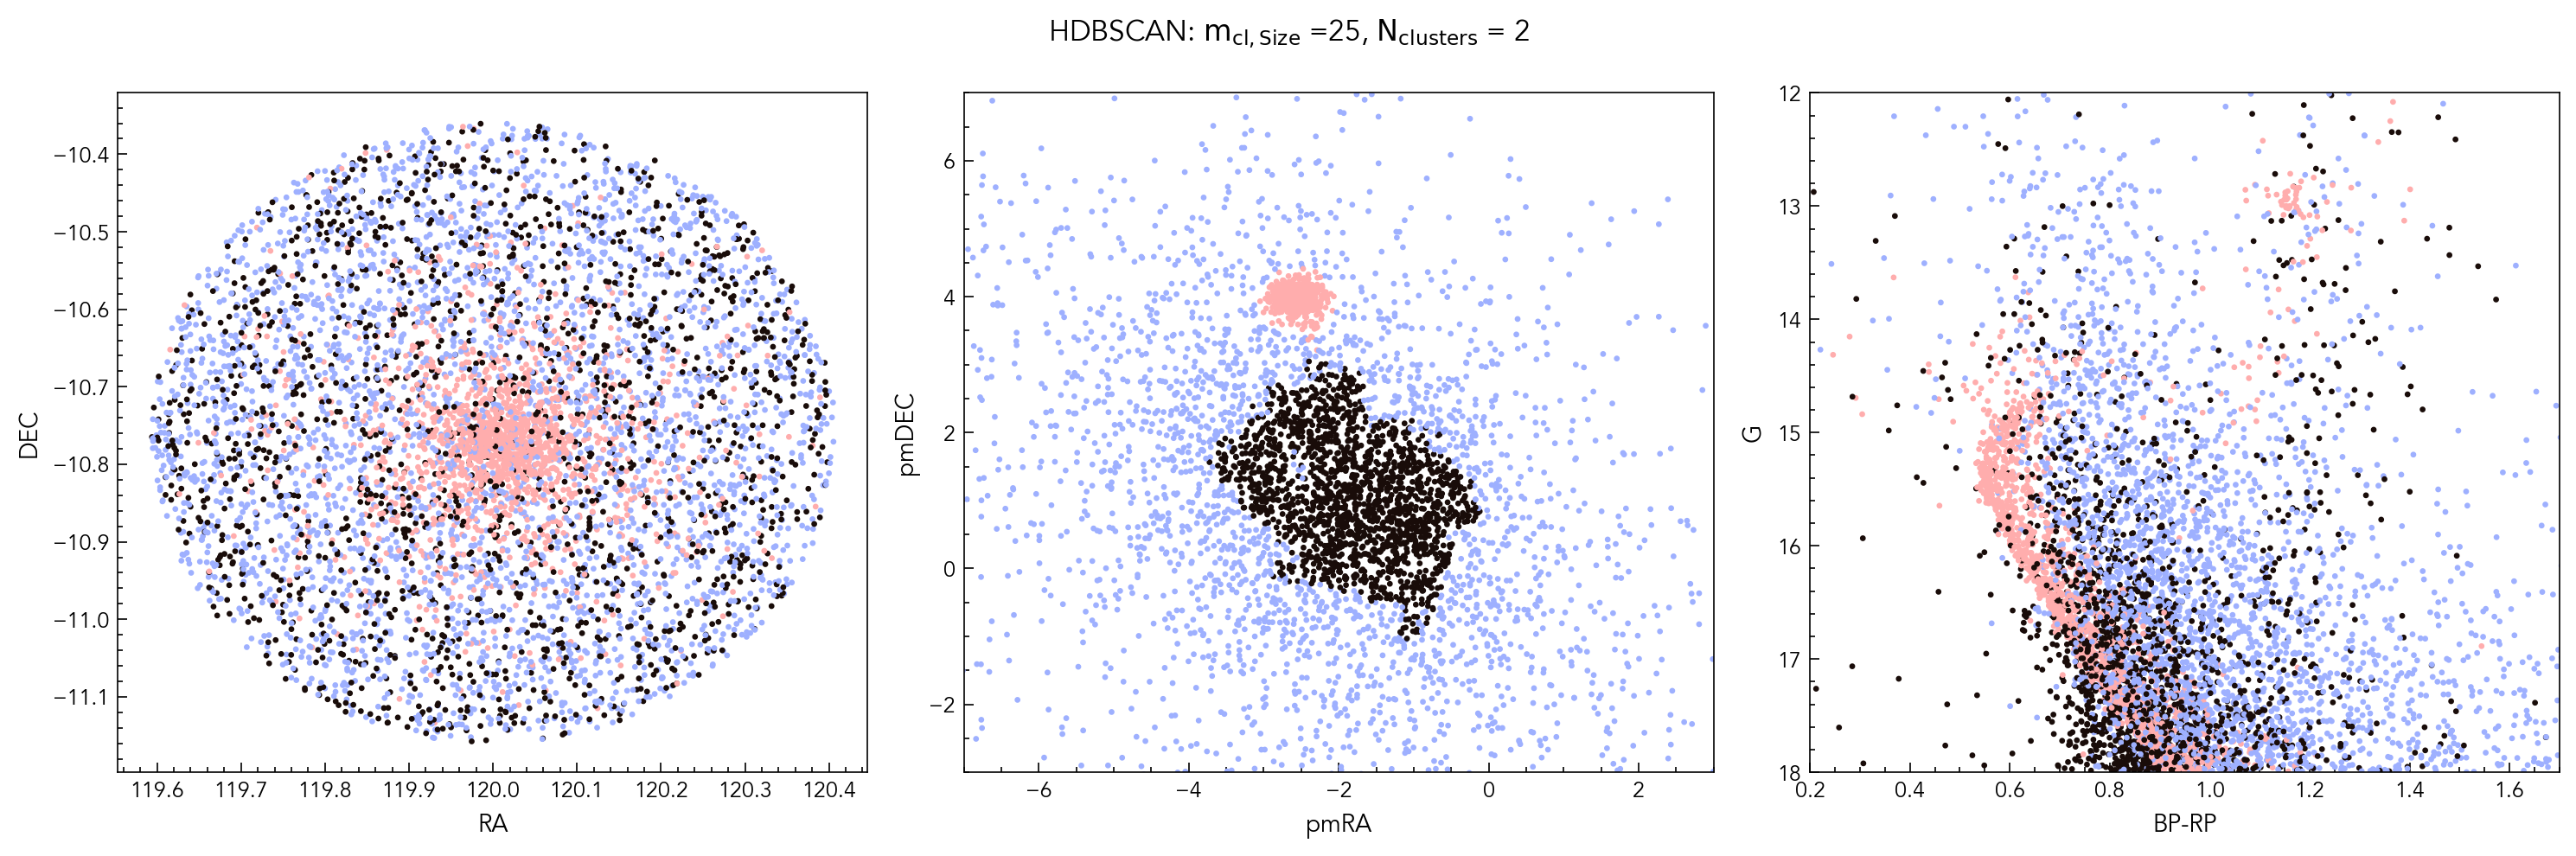

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
plt.suptitle(r'HDBSCAN: $m_{\mathrm{cl,Size}}$ =' + f'{hdb.min_cluster_size}, ' + r'$N_{\mathrm{clusters}}$ = ' + f'{n_clusters_}')

ax1.scatter(df_cluster['ra'], df_cluster['dec'], c = hdb.labels_, s = 2, cmap = cmap)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

ax2.scatter(df_cluster['pmra'], df_cluster['pmdec'], c = hdb.labels_, s = 2, cmap = cmap)
ax2.set_xlim(-7,3), ax2.set_ylim(-3,7)
ax2.set_xlabel('pmRA')
ax2.set_ylabel('pmDEC')

ax3.scatter(df_cluster['bp_rp'], df_cluster['phot_g_mean_mag'], c = hdb.labels_, s = 2, cmap = cmap)
ax3.set_xlim(0.2,1.7), ax3.set_ylim(18,12)
ax3.set_xlabel('BP-RP')
ax3.set_ylabel('G')

plt.show()

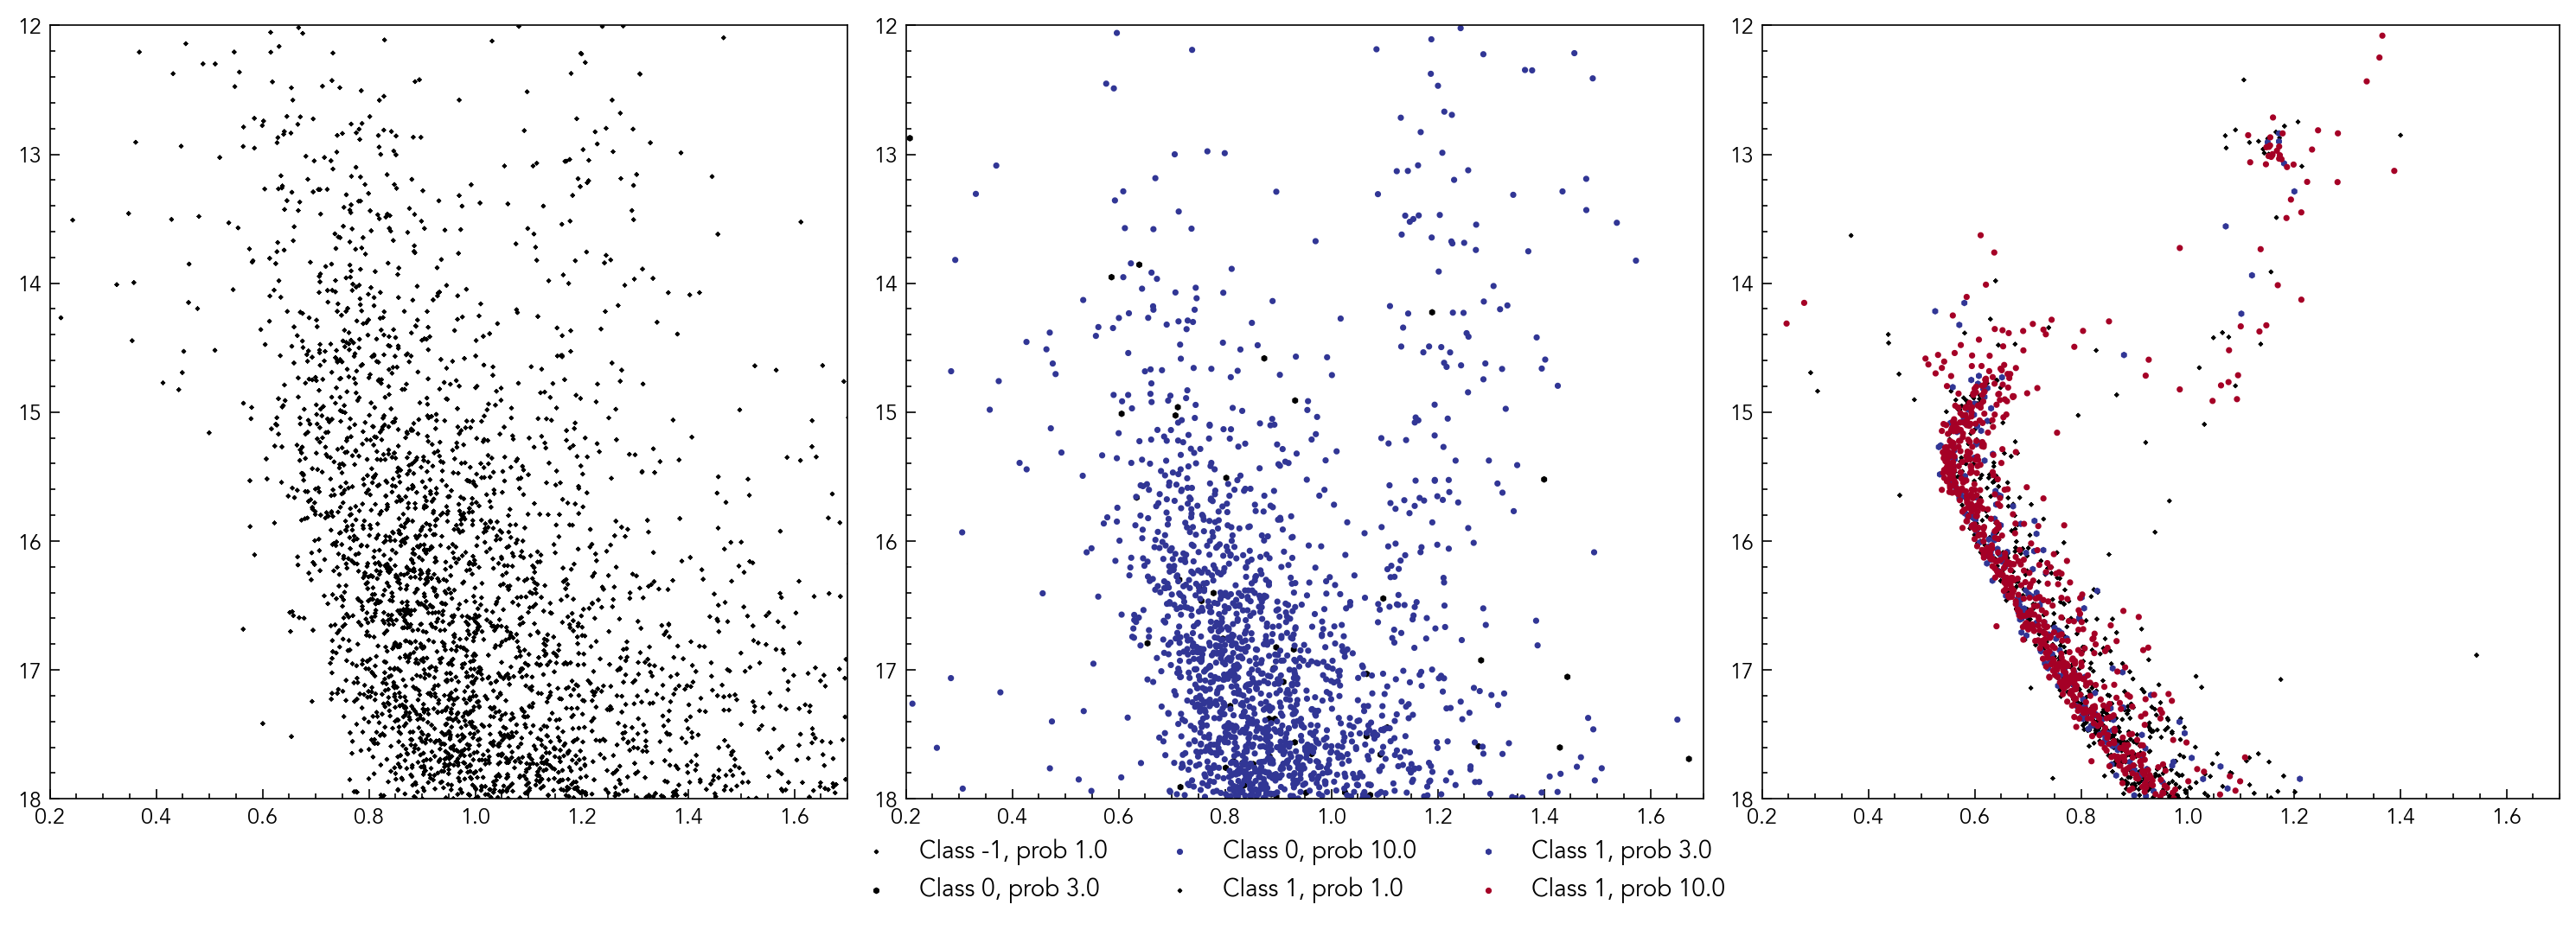

In [24]:
fig, ax = plt.subplots(1, len(set(hdb.labels_)), figsize=(15, 5))
all_handles = []
all_labels = []

for i, pop in enumerate(sorted(set(hdb.labels_))):

    proba = hdb.probabilities_[hdb.labels_ == pop]

    markers = np.full_like(proba, 'x', dtype='<U1') # Default for high probability
    markers[proba > 0.9] = '.' 
    markers[(proba <= 0.9) & (proba > 0.7)] = 'h' 
    
    sizes = np.ones_like(proba) 
    sizes[proba > 0.9] = 10   
    sizes[(proba <= 0.9) & (proba > 0.7)] = 3 

    unique_markers = np.unique(markers)[::-1]
    for marker in unique_markers:
        mask = markers == marker    # Mask for the current marker
        ax[i].scatter(df_cluster['bp_rp'][hdb.labels_ == pop][mask], 
                      df_cluster['phot_g_mean_mag'][hdb.labels_ == pop][mask], 
                      marker=marker, 
                      s=sizes[mask],
                      label=f'Class {pop}, prob {sizes[mask][0]}',)
    
    ax[i].set_xlim(0.2, 1.7)
    ax[i].set_ylim(18, 12)

    handles, labels = ax[i].get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)
# Add legend below x-axis
handles, labels = ax[2].get_legend_handles_labels()
fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=3)

plt.show()


In [12]:
aPer = pd.read_csv('../data/aPer.csv')

X_aPer = np.array([aPer['pmra'] , aPer['pmdec'], aPer['ra'], aPer['dec'], aPer['parallax']]).T
db_aPer = DBSCAN(eps=0.3, min_samples=50).fit(X_aPer)

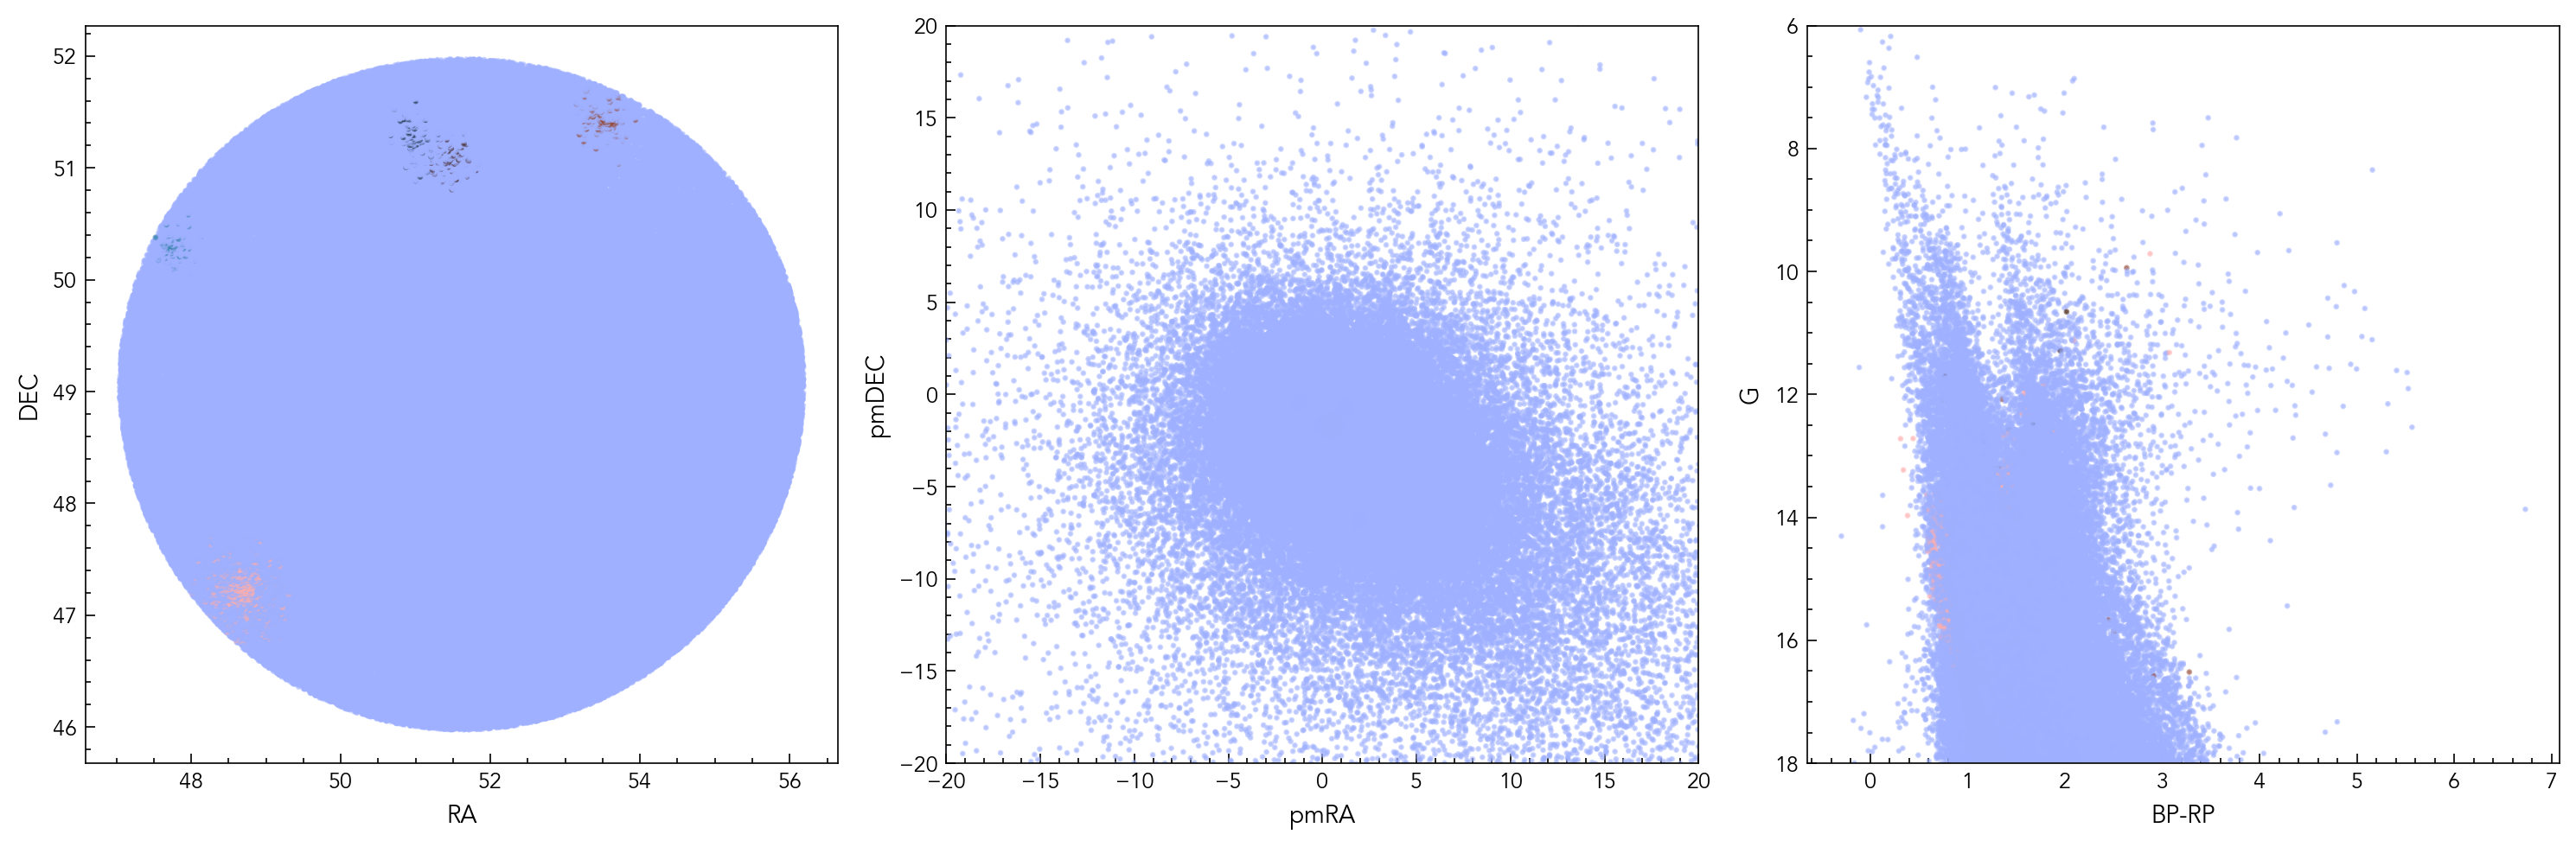

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.scatter(aPer['ra'], aPer['dec'], c = db_aPer.labels_, s = 2, cmap = cmap, alpha = 0.5)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')


ax2.scatter(aPer['pmra'], aPer['pmdec'], c = db_aPer.labels_, s = 2, cmap = cmap, alpha = 0.5)
ax2.set_xlim(-20, 20), ax2.set_ylim(-20, 20)
ax2.set_xlabel('pmRA')
ax2.set_ylabel('pmDEC')

ax3.scatter(aPer['bp_rp'], aPer['phot_g_mean_mag'], c = db_aPer.labels_, s = 2, cmap = cmap, alpha = 0.5)
ax3.set_ylim(18,6)
ax3.set_xlabel('BP-RP')
ax3.set_ylabel('G')


plt.show()


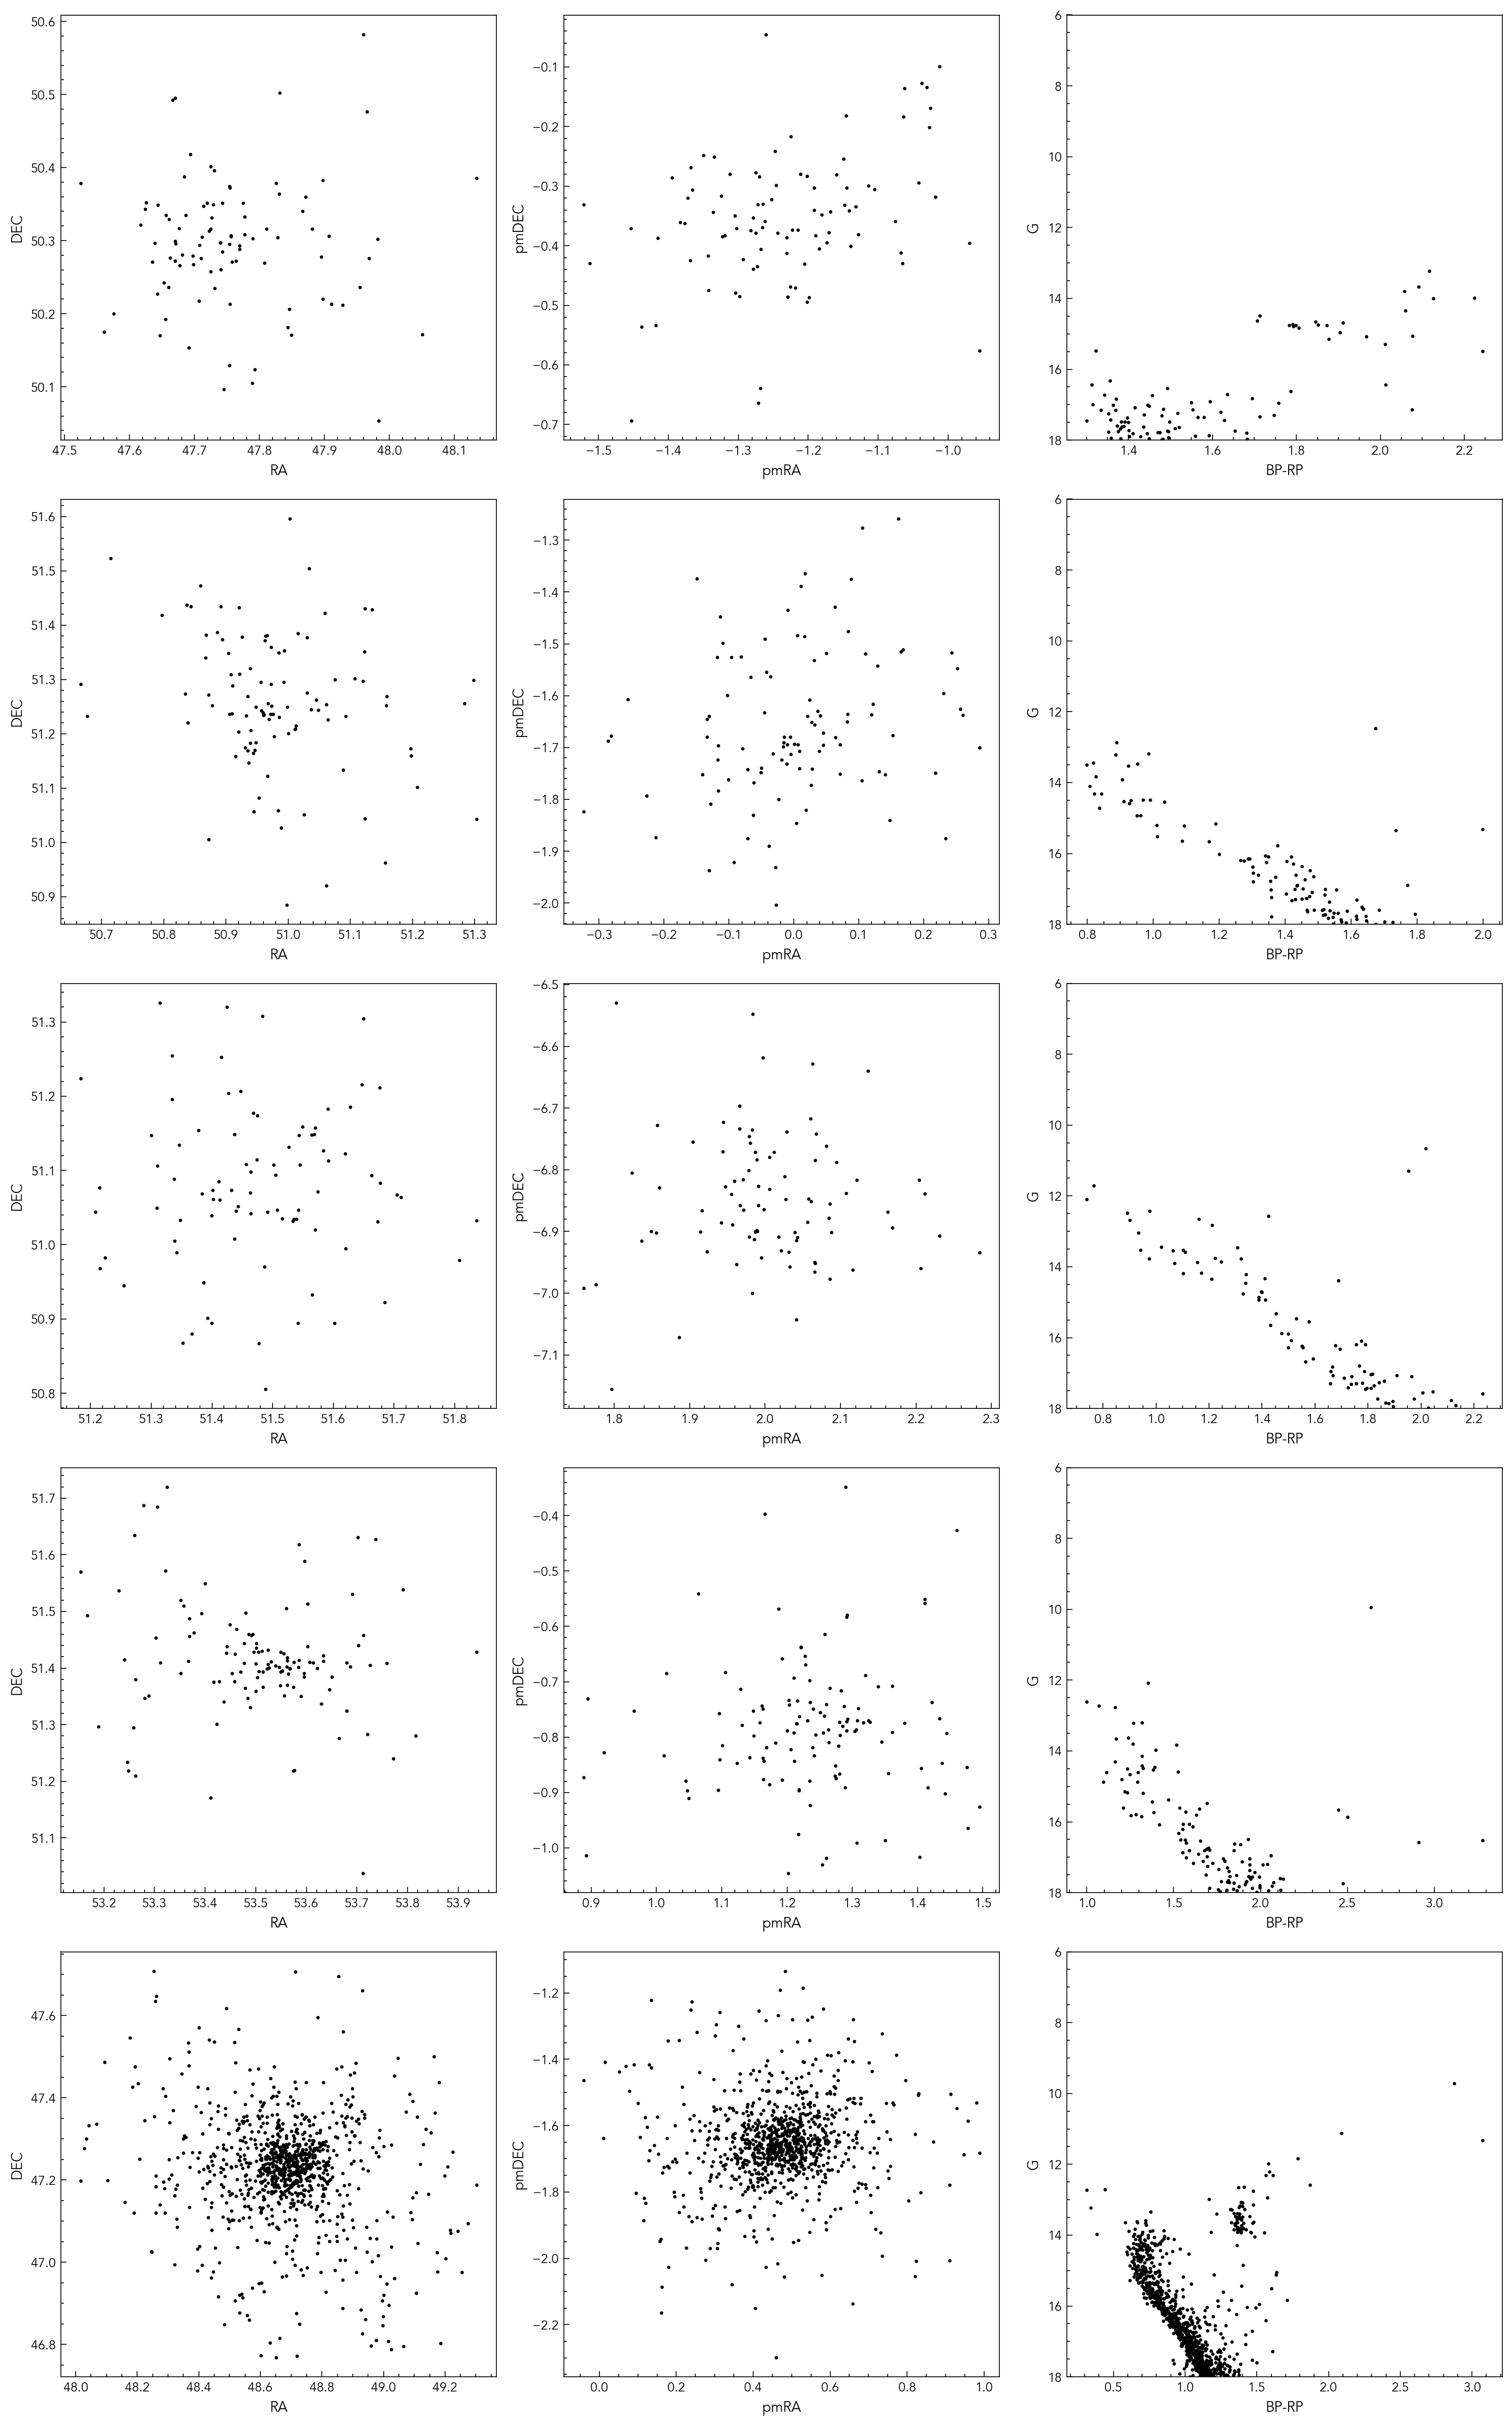

In [34]:
n_populations = len(set(db_aPer.labels_))
fig, axes = plt.subplots(n_populations - 1, 3, figsize=(15, 4 * n_populations))

for pop in range(n_populations-1):
    ax1, ax2, ax3 = axes[pop]

    # Plot RA vs DEC
    ax1.scatter(aPer['ra'][db_aPer.labels_ == pop], aPer['dec'][db_aPer.labels_ == pop], s=2)
    ax1.set_xlabel('RA')
    ax1.set_ylabel('DEC')

    # Plot pmRA vs pmDEC
    ax2.scatter(aPer['pmra'][db_aPer.labels_ == pop], aPer['pmdec'][db_aPer.labels_ == pop], s=2)

    ax2.set_xlabel('pmRA')
    ax2.set_ylabel('pmDEC')

    # Plot BP-RP vs G
    ax3.scatter(aPer['bp_rp'][db_aPer.labels_ == pop], aPer['phot_g_mean_mag'][db_aPer.labels_ == pop], s=2)
    ax3.set_ylim(18, 6)
    ax3.set_xlabel('BP-RP')
    ax3.set_ylabel('G')

plt.tight_layout()
plt.show()